In [1]:
import sys
sys.path.append("../src/utils")
from utils import SimpleGraphVoltDatasetLoader_Lazy
from models import RNN_LSTM
from tqdm import tqdm
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
from torch_geometric import seed_everything


In [2]:
trafo_id = "T1330"
num_timesteps_in = 12
num_timesteps_out = 4
test_ratio_vs_eval_ratio = 0.5
node_id = 50
hidden = 64
layers = 1
batch = 1024
device_str = 'cpu'
epochs = 200
learning_rate = 0.1
model_name = "RNN_LSTM"
manual_seed = 42

In [ ]:
if device_str == 'cuda':
    torch.cuda.empty_cache()


In [3]:
seed_everything(manual_seed)

In [4]:
print("Loading data...")
loader = SimpleGraphVoltDatasetLoader_Lazy(trafo_id, num_timesteps_in, num_timesteps_out)
print(" done")
loader_data_index = loader.snapshot_index

train_dataset, test_eval_dataset = loader.temporal_signal_split_lazy_cut(loader_data_index)
eval_dataset, test_dataset = loader.temporal_signal_split_lazy(test_eval_dataset, train_ratio=test_ratio_vs_eval_ratio)


Loading data...
Voltage index: 5
 done


In [5]:
device = torch.device(device_str)
model = RNN_LSTM(loader.num_features, num_timesteps_out, hidden, layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, verbose=True)

In [6]:


#get dateime string of now
now = pd.Timestamp.now().strftime("%Y%m%d%H%M%S")

name = f"../models/final/{model.name}_{now}_{trafo_id}_epochs-{epochs}_in-{num_timesteps_in}_out-{num_timesteps_out}_train-ratio-1month_lr-{learning_rate}_hidden-{hidden}_layers-{layers}_batch-{batch}_nodeid-{node_id}.pt"
name_txt = f"../models/final/{model.name}_{now}_{trafo_id}_epochs-{epochs}_in-{num_timesteps_in}_out-{num_timesteps_out}_train-ratio-1month_lr-{learning_rate}_hidden-{hidden}_layers-{layers}_batch-{batch}_nodeid-{node_id}.txt"

In [7]:
epoch_losses_train = []
epoch_losses_eval = []

for epoch in range(epochs):
    model.train()
    epoch_loss_train = 0
    for i in tqdm(range(len(train_dataset)//batch+1)):
        #----------BATCHING----------
        start = i*batch
        end = (i+1)*batch
        if end > len(train_dataset):
            end = len(train_dataset)
        snapshots_inds = train_dataset[start:end]
        snapshots = [loader.get_snapshot(snapshot_i) for snapshot_i in snapshots_inds]
        x = torch.stack([snapshot.x[node_id, :, :] for snapshot in snapshots], dim=0)
        y = torch.stack([snapshot.y[node_id, :] for snapshot in snapshots], dim=0)
        x = x.to(device)
        y = y.to(device)
        #----------BATCHING----------
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn()(out, y)
        loss.backward()
        optimizer.step()
        epoch_loss_train += loss.detach().cpu().numpy()
    if scheduler is not None:
        scheduler.step(epoch_loss_train)
    epoch_losses_train.append(epoch_loss_train)
    model.eval()
    epoch_loss_test = 0
    with torch.no_grad():
        for i in tqdm(range(len(eval_dataset)//batch+1)):
            #----------BATCHING----------
            start = i*batch
            end = (i+1)*batch
            if end > len(eval_dataset):
                end = len(eval_dataset)
            snapshots_inds = eval_dataset[start:end]
            snapshots = [loader.get_snapshot(snapshot_i) for snapshot_i in snapshots_inds]
            x = torch.stack([snapshot.x[node_id, :, :] for snapshot in snapshots], dim=0)
            y = torch.stack([snapshot.y[node_id, :] for snapshot in snapshots], dim=0)
            x = x.to(device)
            y = y.to(device)
            #----------BATCHING----------
            out = model(x)
            loss = loss_fn()(out, y)
            epoch_loss_test += loss.detach().cpu().numpy()
        epoch_losses_eval.append(epoch_loss_test)
        if min(epoch_losses_eval) == epoch_loss_test:
            torch.save(model.state_dict(), name)
    print("Epoch {}: Train loss: {}, Test loss: {}".format(epoch, epoch_loss_train, epoch_loss_test))

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.18it/s]


Epoch 0: Train loss: 13.493666008114815, Test loss: 7.806755065917969


100%|██████████| 2/2 [00:00<00:00,  8.15it/s]


Epoch 1: Train loss: 10.745900869369507, Test loss: 1.3545074462890625


100%|██████████| 2/2 [00:00<00:00,  7.97it/s]


Epoch 2: Train loss: 1.5609598755836487, Test loss: 2.473478853702545


100%|██████████| 2/2 [00:00<00:00,  8.74it/s]


Epoch 3: Train loss: 0.958877757191658, Test loss: 0.5905114263296127


100%|██████████| 2/2 [00:00<00:00,  7.94it/s]


Epoch 4: Train loss: 0.8718706369400024, Test loss: 0.5298912674188614


100%|██████████| 2/2 [00:00<00:00,  9.25it/s]


Epoch 5: Train loss: 0.7163191735744476, Test loss: 1.3806952834129333


100%|██████████| 2/2 [00:00<00:00,  8.94it/s]


Epoch 6: Train loss: 0.7782103717327118, Test loss: 1.057614415884018


100%|██████████| 2/2 [00:00<00:00,  8.26it/s]


Epoch 7: Train loss: 0.5852098613977432, Test loss: 0.5021881759166718


100%|██████████| 2/2 [00:00<00:00,  8.97it/s]


Epoch 8: Train loss: 0.6380867958068848, Test loss: 0.7951155602931976


100%|██████████| 2/2 [00:00<00:00,  8.45it/s]


Epoch 9: Train loss: 0.5577249526977539, Test loss: 1.097252070903778


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


Epoch 10: Train loss: 0.45752212405204773, Test loss: 0.6364118307828903


100%|██████████| 2/2 [00:00<00:00,  7.64it/s]


Epoch 11: Train loss: 0.4457928538322449, Test loss: 0.7480226755142212


100%|██████████| 2/2 [00:00<00:00,  6.61it/s]


Epoch 12: Train loss: 0.4234159216284752, Test loss: 0.9950398802757263


100%|██████████| 2/2 [00:00<00:00,  9.04it/s]


Epoch 13: Train loss: 0.3721909075975418, Test loss: 0.7175839245319366


100%|██████████| 2/2 [00:00<00:00,  9.23it/s]


Epoch 14: Train loss: 0.3725476861000061, Test loss: 0.8253859579563141


100%|██████████| 2/2 [00:00<00:00,  8.77it/s]


Epoch 15: Train loss: 0.3611275181174278, Test loss: 0.8963721096515656


100%|██████████| 2/2 [00:00<00:00,  7.27it/s]


Epoch 16: Train loss: 0.35195787996053696, Test loss: 0.7929333448410034


100%|██████████| 2/2 [00:00<00:00,  8.53it/s]


Epoch 17: Train loss: 0.3465803787112236, Test loss: 0.9234789609909058


100%|██████████| 2/2 [00:00<00:00,  8.64it/s]


Epoch 18: Train loss: 0.34021884202957153, Test loss: 0.8419488668441772


100%|██████████| 2/2 [00:00<00:00,  8.37it/s]


Epoch 19: Train loss: 0.3345516696572304, Test loss: 0.8193301856517792


100%|██████████| 2/2 [00:00<00:00,  8.84it/s]


Epoch 20: Train loss: 0.33106864988803864, Test loss: 0.8924694657325745


100%|██████████| 2/2 [00:00<00:00,  7.11it/s]


Epoch 21: Train loss: 0.3270355612039566, Test loss: 0.8591069877147675


100%|██████████| 2/2 [00:00<00:00,  9.51it/s]


Epoch 22: Train loss: 0.3176461532711983, Test loss: 0.9033041298389435


100%|██████████| 2/2 [00:00<00:00,  6.68it/s]


Epoch 23: Train loss: 0.312010794878006, Test loss: 0.8413896262645721


100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


Epoch 24: Train loss: 0.30637113004922867, Test loss: 0.901699423789978


100%|██████████| 2/2 [00:00<00:00,  6.63it/s]


Epoch 25: Train loss: 0.2992766574025154, Test loss: 0.858779788017273


100%|██████████| 2/2 [00:00<00:00,  8.06it/s]


Epoch 26: Train loss: 0.29005424678325653, Test loss: 0.8294649422168732


100%|██████████| 2/2 [00:00<00:00,  6.61it/s]


Epoch 27: Train loss: 0.2859213426709175, Test loss: 0.8450298607349396


100%|██████████| 2/2 [00:00<00:00, 10.64it/s]


Epoch 28: Train loss: 0.27741067856550217, Test loss: 0.8252387940883636


100%|██████████| 2/2 [00:00<00:00,  7.35it/s]


Epoch 29: Train loss: 0.2692161500453949, Test loss: 0.8108275830745697


100%|██████████| 2/2 [00:00<00:00,  8.13it/s]


Epoch 30: Train loss: 0.2605231776833534, Test loss: 0.755992203950882


100%|██████████| 2/2 [00:00<00:00,  6.94it/s]


Epoch 31: Train loss: 0.2599219083786011, Test loss: 0.8206696510314941


100%|██████████| 2/2 [00:00<00:00,  9.97it/s]


Epoch 32: Train loss: 0.27393852174282074, Test loss: 0.9176143705844879


100%|██████████| 2/2 [00:00<00:00,  6.94it/s]


Epoch 33: Train loss: 0.27904892712831497, Test loss: 0.919327050447464


100%|██████████| 2/2 [00:00<00:00,  9.50it/s]


Epoch 34: Train loss: 0.25327345728874207, Test loss: 0.6825330406427383


100%|██████████| 2/2 [00:00<00:00,  6.78it/s]


Epoch 35: Train loss: 0.27709365636110306, Test loss: 0.8636879324913025


100%|██████████| 2/2 [00:00<00:00,  9.15it/s]


Epoch 36: Train loss: 0.23848462104797363, Test loss: 0.6929357647895813


100%|██████████| 2/2 [00:00<00:00,  6.70it/s]


Epoch 37: Train loss: 0.24306107312440872, Test loss: 0.7979905903339386


100%|██████████| 2/2 [00:00<00:00,  8.49it/s]


Epoch 38: Train loss: 0.23323672264814377, Test loss: 0.794382244348526


100%|██████████| 2/2 [00:00<00:00,  6.63it/s]


Epoch 39: Train loss: 0.2226329743862152, Test loss: 0.6699799597263336


100%|██████████| 2/2 [00:00<00:00,  8.80it/s]


Epoch 40: Train loss: 0.22543049603700638, Test loss: 0.7162711024284363


100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


Epoch 41: Train loss: 0.21404645591974258, Test loss: 0.6935655772686005


100%|██████████| 2/2 [00:00<00:00,  9.54it/s]


Epoch 42: Train loss: 0.21127064526081085, Test loss: 0.6445666551589966


100%|██████████| 2/2 [00:00<00:00,  6.68it/s]


Epoch 43: Train loss: 0.20719017088413239, Test loss: 0.6211549043655396


100%|██████████| 2/2 [00:00<00:00,  7.46it/s]


Epoch 44: Train loss: 0.20169750973582268, Test loss: 0.5707810074090958


100%|██████████| 2/2 [00:00<00:00,  6.61it/s]


Epoch 45: Train loss: 0.20086655765771866, Test loss: 0.5862442851066589


100%|██████████| 2/2 [00:00<00:00, 10.90it/s]


Epoch 46: Train loss: 0.19904563575983047, Test loss: 0.5866507291793823


100%|██████████| 2/2 [00:00<00:00,  6.62it/s]


Epoch 47: Train loss: 0.19592790305614471, Test loss: 0.5793789178133011


100%|██████████| 2/2 [00:00<00:00, 10.56it/s]


Epoch 48: Train loss: 0.18642056360840797, Test loss: 0.4585318863391876


100%|██████████| 2/2 [00:00<00:00,  6.41it/s]


Epoch 49: Train loss: 0.19365103915333748, Test loss: 0.5276416093111038


100%|██████████| 2/2 [00:00<00:00,  9.53it/s]


Epoch 50: Train loss: 0.18944739177823067, Test loss: 0.6059919744729996


100%|██████████| 2/2 [00:00<00:00,  6.70it/s]


Epoch 51: Train loss: 0.18911470100283623, Test loss: 0.6055856347084045


100%|██████████| 2/2 [00:00<00:00,  9.07it/s]


Epoch 52: Train loss: 0.18229619786143303, Test loss: 0.4949352294206619


100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


Epoch 53: Train loss: 0.18442866206169128, Test loss: 0.4323207214474678


100%|██████████| 2/2 [00:00<00:00,  7.56it/s]


Epoch 54: Train loss: 0.19921895116567612, Test loss: 0.5652323514223099


100%|██████████| 2/2 [00:00<00:00,  5.23it/s]


Epoch 55: Train loss: 0.19851577654480934, Test loss: 0.695581391453743


100%|██████████| 2/2 [00:00<00:00,  7.77it/s]


Epoch 56: Train loss: 0.2084619700908661, Test loss: 0.478354811668396


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Epoch 57: Train loss: 0.19651289284229279, Test loss: 0.488106444478035


100%|██████████| 2/2 [00:00<00:00,  9.46it/s]


Epoch 58: Train loss: 0.1874673329293728, Test loss: 0.6468512862920761


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


Epoch 59: Train loss: 0.1790410913527012, Test loss: 0.4675403833389282


100%|██████████| 2/2 [00:00<00:00,  8.50it/s]


Epoch 60: Train loss: 0.175298273563385, Test loss: 0.5000005513429642


100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


Epoch 61: Train loss: 0.1807980202138424, Test loss: 0.5944470316171646


100%|██████████| 2/2 [00:00<00:00,  8.85it/s]


Epoch 62: Train loss: 0.1765414997935295, Test loss: 0.4460172727704048


100%|██████████| 2/2 [00:00<00:00,  9.40it/s]


Epoch 63: Train loss: 0.17287852987647057, Test loss: 0.4935513287782669


100%|██████████| 2/2 [00:00<00:00,  8.04it/s]


Epoch 64: Train loss: 0.16499438136816025, Test loss: 0.5514824688434601


100%|██████████| 2/2 [00:00<00:00,  9.65it/s]


Epoch 65: Train loss: 0.1652926206588745, Test loss: 0.5089869946241379


100%|██████████| 2/2 [00:00<00:00,  9.62it/s]


Epoch 66: Train loss: 0.15766127780079842, Test loss: 0.4377652257680893


100%|██████████| 2/2 [00:00<00:00, 10.31it/s]


Epoch 67: Train loss: 0.1630706712603569, Test loss: 0.5256687253713608


100%|██████████| 2/2 [00:00<00:00,  9.42it/s]


Epoch 68: Train loss: 0.16007966548204422, Test loss: 0.5989330112934113


100%|██████████| 2/2 [00:00<00:00,  9.60it/s]


Epoch 69: Train loss: 0.1607225500047207, Test loss: 0.46603524684906006


100%|██████████| 2/2 [00:00<00:00,  9.74it/s]


Epoch 70: Train loss: 0.15604384243488312, Test loss: 0.41063594073057175


100%|██████████| 2/2 [00:00<00:00,  6.81it/s]


Epoch 71: Train loss: 0.16311556100845337, Test loss: 0.5592506676912308


100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


Epoch 72: Train loss: 0.16586608439683914, Test loss: 0.607694074511528


100%|██████████| 2/2 [00:00<00:00, 10.16it/s]


Epoch 73: Train loss: 0.16371462866663933, Test loss: 0.4230906814336777


100%|██████████| 2/2 [00:00<00:00, 10.67it/s]


Epoch 74: Train loss: 0.1600072719156742, Test loss: 0.3985137417912483


100%|██████████| 2/2 [00:00<00:00,  7.92it/s]


Epoch 75: Train loss: 0.1664332076907158, Test loss: 0.5912550836801529


100%|██████████| 2/2 [00:00<00:00,  7.34it/s]


Epoch 76: Train loss: 0.17018890008330345, Test loss: 0.5339562743902206


100%|██████████| 2/2 [00:00<00:00,  9.76it/s]


Epoch 77: Train loss: 0.1567302644252777, Test loss: 0.38791385293006897


100%|██████████| 2/2 [00:00<00:00, 10.00it/s]


Epoch 78: Train loss: 0.15990961715579033, Test loss: 0.4818273335695267


100%|██████████| 2/2 [00:00<00:00,  8.34it/s]


Epoch 79: Train loss: 0.14527832716703415, Test loss: 0.5361580848693848


100%|██████████| 2/2 [00:00<00:00,  9.08it/s]


Epoch 80: Train loss: 0.1452336572110653, Test loss: 0.4656538963317871


100%|██████████| 2/2 [00:00<00:00,  9.48it/s]


Epoch 81: Train loss: 0.13959527015686035, Test loss: 0.4032555967569351


100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


Epoch 82: Train loss: 0.14363062381744385, Test loss: 0.49535562098026276


100%|██████████| 2/2 [00:00<00:00,  8.85it/s]


Epoch 83: Train loss: 0.14116712287068367, Test loss: 0.5155893266201019


100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


Epoch 84: Train loss: 0.13851679861545563, Test loss: 0.4545033276081085


100%|██████████| 2/2 [00:00<00:00, 10.77it/s]


Epoch 85: Train loss: 0.13892530649900436, Test loss: 0.40611277520656586


100%|██████████| 2/2 [00:00<00:00,  8.27it/s]


Epoch 86: Train loss: 0.14820903912186623, Test loss: 0.446293406188488


100%|██████████| 2/2 [00:00<00:00, 10.52it/s]


Epoch 87: Train loss: 0.15184466168284416, Test loss: 0.5655539631843567


100%|██████████| 2/2 [00:00<00:00, 10.12it/s]


Epoch 88: Train loss: 0.16165072470903397, Test loss: 0.48353971540927887


100%|██████████| 2/2 [00:00<00:00, 10.13it/s]


Epoch 89: Train loss: 0.1589680016040802, Test loss: 0.4217909723520279


100%|██████████| 2/2 [00:00<00:00,  7.79it/s]


Epoch 90: Train loss: 0.17619803547859192, Test loss: 0.4758281260728836


100%|██████████| 2/2 [00:00<00:00,  9.36it/s]


Epoch 91: Train loss: 0.15921036154031754, Test loss: 0.5460090339183807


100%|██████████| 2/2 [00:00<00:00,  9.75it/s]


Epoch 92: Train loss: 0.15889623388648033, Test loss: 0.3895157426595688


100%|██████████| 2/2 [00:00<00:00,  9.95it/s]


Epoch 93: Train loss: 0.1497887559235096, Test loss: 0.43464525043964386


100%|██████████| 2/2 [00:00<00:00,  9.33it/s]


Epoch 94: Train loss: 0.15401848405599594, Test loss: 0.5622084438800812


100%|██████████| 3/3 [00:01<00:00,  2.76it/s]


Epoch 00096: reducing learning rate of group 0 to 1.0000e-02.


100%|██████████| 2/2 [00:00<00:00,  6.86it/s]


Epoch 95: Train loss: 0.15666477754712105, Test loss: 0.44174517691135406


100%|██████████| 2/2 [00:00<00:00, 10.66it/s]


Epoch 96: Train loss: 0.14014382660388947, Test loss: 0.4640251249074936


100%|██████████| 2/2 [00:00<00:00,  7.82it/s]


Epoch 97: Train loss: 0.1368364356458187, Test loss: 0.47345419228076935


100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


Epoch 98: Train loss: 0.13233285397291183, Test loss: 0.46368247270584106


100%|██████████| 2/2 [00:00<00:00,  9.71it/s]


Epoch 99: Train loss: 0.12992941588163376, Test loss: 0.4520741105079651


100%|██████████| 2/2 [00:00<00:00,  8.84it/s]


Epoch 100: Train loss: 0.1295761913061142, Test loss: 0.45141778886318207


100%|██████████| 2/2 [00:00<00:00,  8.81it/s]


Epoch 101: Train loss: 0.1288890466094017, Test loss: 0.4568423479795456


100%|██████████| 2/2 [00:00<00:00,  9.24it/s]


Epoch 102: Train loss: 0.12818947434425354, Test loss: 0.4566097557544708


100%|██████████| 2/2 [00:00<00:00,  9.95it/s]


Epoch 103: Train loss: 0.12708906829357147, Test loss: 0.4495503306388855


100%|██████████| 2/2 [00:00<00:00,  8.29it/s]


Epoch 104: Train loss: 0.12617141753435135, Test loss: 0.44446974992752075


100%|██████████| 2/2 [00:00<00:00,  7.22it/s]


Epoch 105: Train loss: 0.12579146027565002, Test loss: 0.44588468968868256


100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


Epoch 106: Train loss: 0.12540989741683006, Test loss: 0.4487995505332947


100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


Epoch 107: Train loss: 0.12493568286299706, Test loss: 0.4473610520362854


100%|██████████| 2/2 [00:00<00:00,  9.41it/s]


Epoch 108: Train loss: 0.12441027164459229, Test loss: 0.44333286583423615


100%|██████████| 2/2 [00:00<00:00,  8.90it/s]


Epoch 109: Train loss: 0.12408985570073128, Test loss: 0.44183826446533203


100%|██████████| 2/2 [00:00<00:00,  9.48it/s]


Epoch 110: Train loss: 0.12386196479201317, Test loss: 0.4435478448867798


100%|██████████| 2/2 [00:00<00:00,  9.55it/s]


Epoch 111: Train loss: 0.12361899390816689, Test loss: 0.4449321925640106


100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


Epoch 112: Train loss: 0.12335623428225517, Test loss: 0.44400425255298615


100%|██████████| 2/2 [00:00<00:00, 10.03it/s]


Epoch 113: Train loss: 0.12308934330940247, Test loss: 0.44253964722156525


100%|██████████| 2/2 [00:00<00:00,  9.21it/s]


Epoch 114: Train loss: 0.12285425513982773, Test loss: 0.44243207573890686


100%|██████████| 2/2 [00:00<00:00,  9.25it/s]


Epoch 115: Train loss: 0.12262753769755363, Test loss: 0.4429713636636734


100%|██████████| 2/2 [00:00<00:00,  9.52it/s]


Epoch 116: Train loss: 0.1224077008664608, Test loss: 0.44274458289146423


100%|██████████| 2/2 [00:00<00:00, 10.12it/s]


Epoch 117: Train loss: 0.1221962571144104, Test loss: 0.44201521575450897


100%|██████████| 2/2 [00:00<00:00, 10.11it/s]


Epoch 118: Train loss: 0.12200437486171722, Test loss: 0.44173088669776917


100%|██████████| 2/2 [00:00<00:00,  7.01it/s]


Epoch 119: Train loss: 0.12182219699025154, Test loss: 0.4416583329439163


100%|██████████| 2/2 [00:00<00:00, 10.62it/s]


Epoch 120: Train loss: 0.12164623290300369, Test loss: 0.4409870505332947


100%|██████████| 2/2 [00:00<00:00,  9.43it/s]


Epoch 121: Train loss: 0.12147010117769241, Test loss: 0.43991953134536743


100%|██████████| 2/2 [00:00<00:00,  7.81it/s]


Epoch 122: Train loss: 0.12129282206296921, Test loss: 0.43935373425483704


100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


Epoch 123: Train loss: 0.12111646309494972, Test loss: 0.4394444227218628


100%|██████████| 2/2 [00:00<00:00,  9.71it/s]


Epoch 124: Train loss: 0.12094387784600258, Test loss: 0.43954259157180786


100%|██████████| 2/2 [00:00<00:00,  9.64it/s]


Epoch 125: Train loss: 0.12077585607767105, Test loss: 0.43929821252822876


100%|██████████| 2/2 [00:00<00:00,  8.21it/s]


Epoch 126: Train loss: 0.12061114981770515, Test loss: 0.4389456957578659


100%|██████████| 2/2 [00:00<00:00,  8.97it/s]


Epoch 127: Train loss: 0.12044909968972206, Test loss: 0.4386240690946579


100%|██████████| 2/2 [00:00<00:00,  9.11it/s]


Epoch 128: Train loss: 0.12029049545526505, Test loss: 0.43817752599716187


100%|██████████| 2/2 [00:00<00:00,  8.15it/s]


Epoch 129: Train loss: 0.12013477832078934, Test loss: 0.437612384557724


100%|██████████| 2/2 [00:00<00:00,  9.59it/s]


Epoch 130: Train loss: 0.11998028308153152, Test loss: 0.43717092275619507


100%|██████████| 2/2 [00:00<00:00,  9.39it/s]


Epoch 131: Train loss: 0.119826789945364, Test loss: 0.43691954016685486


100%|██████████| 2/2 [00:00<00:00, 10.44it/s]


Epoch 132: Train loss: 0.11967531964182854, Test loss: 0.43668200075626373


100%|██████████| 2/2 [00:00<00:00,  8.38it/s]


Epoch 133: Train loss: 0.11952592059969902, Test loss: 0.4363749772310257


100%|██████████| 2/2 [00:00<00:00,  9.73it/s]


Epoch 134: Train loss: 0.11937776580452919, Test loss: 0.43607933819293976


100%|██████████| 2/2 [00:00<00:00,  9.86it/s]


Epoch 135: Train loss: 0.11923086270689964, Test loss: 0.43580862879753113


100%|██████████| 2/2 [00:00<00:00,  8.14it/s]


Epoch 136: Train loss: 0.11908568814396858, Test loss: 0.4354870170354843


100%|██████████| 2/2 [00:00<00:00,  8.80it/s]


Epoch 137: Train loss: 0.11894180625677109, Test loss: 0.4351288676261902


100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


Epoch 138: Train loss: 0.11879847571253777, Test loss: 0.43482473492622375


100%|██████████| 2/2 [00:00<00:00, 10.03it/s]


Epoch 139: Train loss: 0.11865594983100891, Test loss: 0.4345846325159073


100%|██████████| 2/2 [00:00<00:00,  9.24it/s]


Epoch 140: Train loss: 0.11851485073566437, Test loss: 0.43434879183769226


100%|██████████| 2/2 [00:00<00:00,  9.61it/s]


Epoch 141: Train loss: 0.11837504059076309, Test loss: 0.4341033548116684


100%|██████████| 2/2 [00:00<00:00,  9.56it/s]


Epoch 142: Train loss: 0.11823614686727524, Test loss: 0.433871328830719


100%|██████████| 2/2 [00:00<00:00,  7.34it/s]


Epoch 143: Train loss: 0.11809812858700752, Test loss: 0.4336480647325516


100%|██████████| 2/2 [00:00<00:00,  9.36it/s]


Epoch 144: Train loss: 0.11796097457408905, Test loss: 0.43342454731464386


100%|██████████| 2/2 [00:00<00:00,  9.04it/s]


Epoch 145: Train loss: 0.11782440170645714, Test loss: 0.4332215338945389


100%|██████████| 2/2 [00:00<00:00,  9.47it/s]


Epoch 146: Train loss: 0.11768840625882149, Test loss: 0.4330495446920395


100%|██████████| 2/2 [00:00<00:00,  8.87it/s]


Epoch 147: Train loss: 0.1175532341003418, Test loss: 0.4328863322734833


100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


Epoch 148: Train loss: 0.11741889640688896, Test loss: 0.4327195882797241


100%|██████████| 2/2 [00:00<00:00,  8.66it/s]


Epoch 149: Train loss: 0.11728516593575478, Test loss: 0.43256238102912903


100%|██████████| 2/2 [00:00<00:00,  7.71it/s]


Epoch 150: Train loss: 0.11715195327997208, Test loss: 0.4324212968349457


100%|██████████| 2/2 [00:00<00:00,  9.24it/s]


Epoch 151: Train loss: 0.11701930314302444, Test loss: 0.432289719581604


100%|██████████| 2/2 [00:00<00:00,  9.74it/s]


Epoch 152: Train loss: 0.1168871745467186, Test loss: 0.43216803669929504


100%|██████████| 2/2 [00:00<00:00, 10.03it/s]


Epoch 153: Train loss: 0.11675550043582916, Test loss: 0.4320605546236038


100%|██████████| 2/2 [00:00<00:00,  6.82it/s]


Epoch 154: Train loss: 0.11662434414029121, Test loss: 0.43196286261081696


100%|██████████| 2/2 [00:00<00:00,  9.45it/s]


Epoch 155: Train loss: 0.11649370938539505, Test loss: 0.43187104165554047


100%|██████████| 2/2 [00:00<00:00,  6.99it/s]


Epoch 156: Train loss: 0.1163635291159153, Test loss: 0.4317900687456131


100%|██████████| 2/2 [00:00<00:00,  8.67it/s]


Epoch 157: Train loss: 0.11623375490307808, Test loss: 0.4317227602005005


100%|██████████| 2/2 [00:00<00:00,  6.52it/s]


Epoch 158: Train loss: 0.1161043792963028, Test loss: 0.43166714906692505


100%|██████████| 2/2 [00:00<00:00, 10.09it/s]


Epoch 159: Train loss: 0.11597540974617004, Test loss: 0.43162332475185394


100%|██████████| 2/2 [00:00<00:00,  6.61it/s]


Epoch 160: Train loss: 0.11584678664803505, Test loss: 0.4315926283597946


100%|██████████| 2/2 [00:00<00:00,  9.41it/s]


Epoch 161: Train loss: 0.1157185547053814, Test loss: 0.43157224357128143


100%|██████████| 2/2 [00:00<00:00,  7.08it/s]


Epoch 162: Train loss: 0.11559069901704788, Test loss: 0.43156008422374725


100%|██████████| 2/2 [00:00<00:00, 10.56it/s]


Epoch 163: Train loss: 0.11546318978071213, Test loss: 0.43155887722969055


100%|██████████| 2/2 [00:00<00:00,  6.81it/s]


Epoch 164: Train loss: 0.11533600464463234, Test loss: 0.4315694570541382


100%|██████████| 2/2 [00:00<00:00,  8.35it/s]


Epoch 165: Train loss: 0.11520916596055031, Test loss: 0.4315899908542633


100%|██████████| 2/2 [00:00<00:00,  6.97it/s]


Epoch 166: Train loss: 0.11508266627788544, Test loss: 0.43161918222904205


100%|██████████| 2/2 [00:00<00:00,  9.98it/s]


Epoch 167: Train loss: 0.11495647206902504, Test loss: 0.43165627121925354


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


Epoch 168: Train loss: 0.11483057960867882, Test loss: 0.43170005083084106


100%|██████████| 2/2 [00:00<00:00,  9.84it/s]


Epoch 169: Train loss: 0.11470498517155647, Test loss: 0.43174973130226135


100%|██████████| 2/2 [00:00<00:00,  6.71it/s]


Epoch 170: Train loss: 0.114579688757658, Test loss: 0.43180564045906067


100%|██████████| 2/2 [00:00<00:00,  9.42it/s]


Epoch 171: Train loss: 0.11445466801524162, Test loss: 0.4318666309118271


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Epoch 172: Train loss: 0.11432992294430733, Test loss: 0.43193139135837555


100%|██████████| 2/2 [00:00<00:00,  9.98it/s]


Epoch 173: Train loss: 0.11420542746782303, Test loss: 0.4319996237754822


100%|██████████| 2/2 [00:00<00:00,  7.11it/s]


Epoch 174: Train loss: 0.11408117413520813, Test loss: 0.43207119405269623


100%|██████████| 2/2 [00:00<00:00,  6.64it/s]


Epoch 175: Train loss: 0.11395714432001114, Test loss: 0.43214549124240875


100%|██████████| 2/2 [00:00<00:00,  6.93it/s]


Epoch 176: Train loss: 0.11383334174752235, Test loss: 0.4322226196527481


100%|██████████| 2/2 [00:00<00:00, 10.44it/s]


Epoch 177: Train loss: 0.11370974779129028, Test loss: 0.4323020279407501


100%|██████████| 2/2 [00:00<00:00,  6.92it/s]


Epoch 178: Train loss: 0.11358633637428284, Test loss: 0.4323834180831909


100%|██████████| 2/2 [00:00<00:00,  8.99it/s]


Epoch 179: Train loss: 0.11346308887004852, Test loss: 0.43246689438819885


100%|██████████| 2/2 [00:00<00:00,  6.55it/s]


Epoch 180: Train loss: 0.11334001645445824, Test loss: 0.4325524866580963


100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


Epoch 181: Train loss: 0.113217081874609, Test loss: 0.4326399713754654


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


Epoch 182: Train loss: 0.1130942776799202, Test loss: 0.4327293485403061


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


Epoch 183: Train loss: 0.11297157406806946, Test loss: 0.43282072246074677


100%|██████████| 2/2 [00:00<00:00,  7.33it/s]


Epoch 184: Train loss: 0.11284897103905678, Test loss: 0.43291325867176056


100%|██████████| 2/2 [00:00<00:00,  9.25it/s]


Epoch 185: Train loss: 0.11272644624114037, Test loss: 0.4330074340105057


100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


Epoch 186: Train loss: 0.11260397359728813, Test loss: 0.4331030994653702


100%|██████████| 2/2 [00:00<00:00,  9.70it/s]


Epoch 187: Train loss: 0.11248153448104858, Test loss: 0.43319985270500183


100%|██████████| 2/2 [00:00<00:00,  6.18it/s]


Epoch 188: Train loss: 0.11235912144184113, Test loss: 0.43329764902591705


100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


Epoch 189: Train loss: 0.11223669722676277, Test loss: 0.43339674174785614


100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


Epoch 190: Train loss: 0.11211428046226501, Test loss: 0.43349647521972656


100%|██████████| 2/2 [00:00<00:00, 10.10it/s]


Epoch 191: Train loss: 0.11199181154370308, Test loss: 0.4335968941450119


100%|██████████| 2/2 [00:00<00:00,  7.20it/s]


Epoch 192: Train loss: 0.11186927929520607, Test loss: 0.4336981028318405


100%|██████████| 2/2 [00:00<00:00,  8.72it/s]


Epoch 193: Train loss: 0.11174667254090309, Test loss: 0.4337998032569885


100%|██████████| 2/2 [00:00<00:00,  7.03it/s]


Epoch 194: Train loss: 0.11162398010492325, Test loss: 0.43390221893787384


100%|██████████| 2/2 [00:00<00:00,  9.38it/s]


Epoch 195: Train loss: 0.11150115355849266, Test loss: 0.4340052902698517


100%|██████████| 2/2 [00:00<00:00,  8.67it/s]


Epoch 196: Train loss: 0.11137819290161133, Test loss: 0.4341092109680176


100%|██████████| 2/2 [00:00<00:00,  7.35it/s]


Epoch 197: Train loss: 0.11125508323311806, Test loss: 0.4342140108346939


100%|██████████| 2/2 [00:00<00:00,  8.68it/s]


Epoch 198: Train loss: 0.11113180220127106, Test loss: 0.434320330619812


100%|██████████| 2/2 [00:00<00:00,  8.98it/s]

Epoch 199: Train loss: 0.11100833117961884, Test loss: 0.4344281852245331


In [26]:
std = loader.mean_and_std["measurements"][1]["voltage"]
mean = loader.mean_and_std["measurements"][0]["voltage"]

In [27]:
model.load_state_dict(torch.load(name))

<All keys matched successfully>

In [28]:
x = torch.stack([loader.get_snapshot(snapshot_i).x[node_id, :, :] for snapshot_i in test_dataset], dim=0)
y = torch.stack([loader.get_snapshot(snapshot_i).y[node_id, :] for snapshot_i in test_dataset], dim=0)
x = x.to(device)
y = y.to(device)
loss_fn = torch.nn.L1Loss

with torch.no_grad():
    model.eval()
    out = model(x)
    loss = loss_fn(reduction="none")(out, y).mean(dim=0).detach().cpu().numpy()

loss_test = loss*std

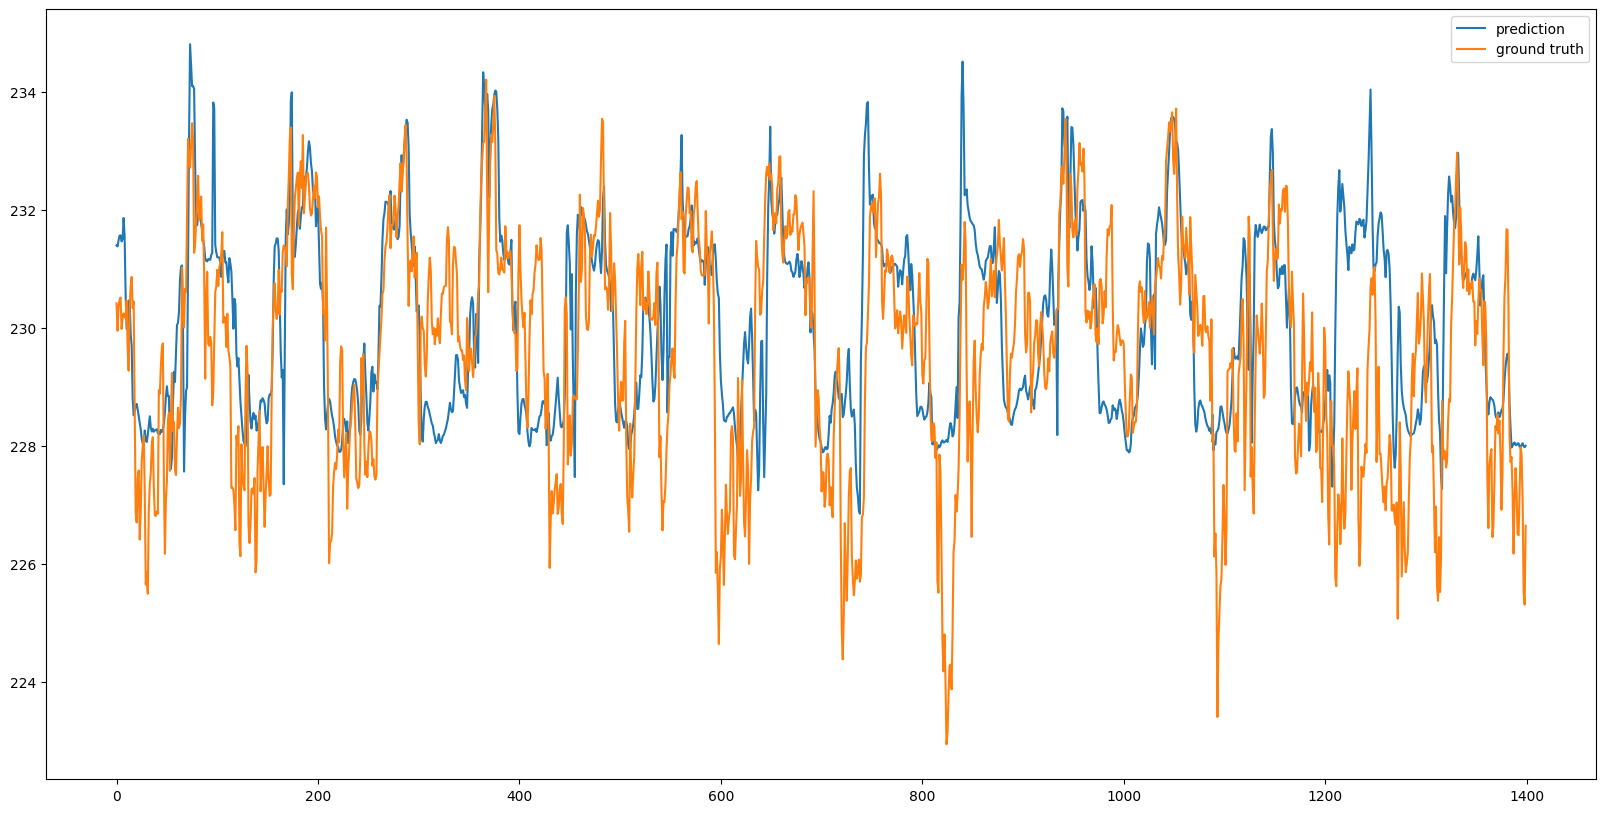

In [29]:
start, end = 0, 1400

import matplotlib.pyplot as plt
#make plot bigger
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot((out*std+mean)[start:end, 0], label="prediction")
plt.plot((y*std+mean)[start:end, 0], label="ground truth")
plt.legend()

In [30]:
#create txt file at name_txt
with open(name_txt, "w") as f:
    #print losses
    f.write("train losses:\n")
    f.write(str(epoch_losses_train))
    f.write("\n")
    f.write("eval losses:\n")
    f.write(str(epoch_losses_eval))
    f.write("\n")
    f.write("test loss:\n")
    f.write(str(loss_test))
    f.write("\n")
    f.write(str(loss_test.mean()))
    f.write("\n")

In [12]:
# torch.Tensor(loader._df_measurments.groupby("node_id").mean()["PMO"].values).repeat(loader._num_timesteps_out, 1).T*loss

In [21]:
loss

array([0.2820639 , 0.28868082, 0.28983414, 0.29320437], dtype=float32)

In [14]:
loader._df_measurments["voltage"].nlargest(70000)*std

2199247    10.157994
2059087    10.141327
7525327    10.124661
2549647    10.057994
867727     10.025327
             ...    
2592632     6.091327
2607629     6.091327
2608935     6.091327
2608972     6.091327
2609301     6.091327
Name: voltage, Length: 70000, dtype: float64

In [15]:
loader._df_measurments["voltage"].nsmallest(70000)*std

7364349   -230.208673
1206751   -116.808673
3335560    -85.292006
3332203    -85.042006
3332395    -85.008673
              ...    
3977157     -6.108673
3980706     -6.108673
3981867     -6.108673
3985703     -6.108673
3986179     -6.108673
Name: voltage, Length: 70000, dtype: float64

In [16]:
0.3/12

0.024999999999999998